## 4.3 ファイルの読み込み

In [141]:
# 4-1 ライブラリの読み込み
import numpy as np
import pandas as pd
import os
import gc
import pickle

# 分布確認
import pandas_profiling as pdp

# 可視化
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

# モデリング
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

import japanize_matplotlib
%matplotlib inline

In [142]:
# 4-2 ファイルの読み込み
df_train = pd.read_csv("../titanic/train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 4.4 データの確認（簡易）

### 4.4.1 レコード数とカラム数の確認

In [143]:
# 4-3 レコード数とカラム数の確認
print(df_train.shape)
print("レコード数:", len(df_train))
print("カラム数:", len(df_train.columns))

(891, 12)
レコード数: 891
カラム数: 12


## 4.4.2 カラムごとのデータの種類の確認

In [144]:
# 4-4 データの確認
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Pclassは「順序尺度」（数値の順序に意味がある）ではあるものの、「間隔尺度」（間隔に意味がある）ものではないので、「カテゴリ変数」と捉えることができる。

In [145]:
# 4-5 データ型の変換
df_train["Pclass"] = df_train["Pclass"].astype(object)
df_train[["Pclass"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Pclass  891 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB


In [146]:
# 4-6 データ型をobject型からint型へ戻す
df_train["Pclass"] = df_train["Pclass"].astype(int)
df_train[["Pclass"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Pclass  891 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB


## 4.4.3 欠損値の確認

In [147]:
# 4-8 欠損値の確認
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## 4.5 データセットの作成

仮定：チケットクラスや旅客運賃の高人の方が、優先的に救助されて生き残りやすそう。

そこで、説明変数として欠損値がなく、数値データである「Pclass」、「Fare」を使用する。

In [148]:
# 4-8 データセットの作成
x_train, y_train, id_train = df_train[["Pclass", "Fare"]],\
                             df_train[["Survived"]],\
                             df_train[["PassengerId"]]

print(x_train.shape, y_train.shape, id_train.shape)

(891, 2) (891, 1) (891, 1)


## 4.6 バリデーション設計

In [149]:
# 4-9 ホールドアウト検証の実行
x_tr, x_va, y_tr, y_va = train_test_split(x_train,
                                          y_train,
                                          test_size=0.2,
                                          shuffle=True,
                                          stratify=y_train,
                                          random_state=1234)
print(x_tr.shape, y_tr.shape)
print(x_va.shape, y_va.shape)

print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
    y_train["Survived"].mean(),
    y_tr["Survived"].mean(),
    y_va["Survived"].mean()
))

(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385


In [150]:
cv[0][0]

array([  0,   1,   4,   5,   6,   7,   8,   9,  10,  11,  13,  14,  15,
        16,  18,  19,  20,  21,  22,  23,  24,  25,  27,  28,  30,  31,
        32,  33,  35,  36,  37,  39,  40,  41,  42,  43,  44,  46,  47,
        49,  50,  51,  52,  53,  54,  58,  59,  60,  63,  64,  65,  66,
        67,  68,  69,  71,  73,  74,  75,  76,  77,  78,  81,  82,  84,
        85,  86,  87,  88,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 106, 107, 109, 110, 111, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 127, 129, 130,
       131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 160, 161,
       162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 190,
       191, 192, 193, 194, 196, 198, 199, 200, 201, 202, 203, 205, 206,
       207, 208, 209, 210, 211, 212, 214, 215, 216, 217, 220, 22

In [151]:
cv[0][1]

array([  2,   3,  12,  17,  26,  29,  34,  38,  45,  48,  55,  56,  57,
        61,  62,  70,  72,  79,  80,  83,  89, 105, 108, 112, 125, 126,
       128, 135, 145, 146, 158, 159, 163, 177, 187, 195, 197, 204, 213,
       218, 219, 221, 223, 227, 237, 238, 239, 250, 255, 257, 258, 267,
       279, 284, 292, 297, 299, 315, 318, 320, 322, 328, 332, 336, 337,
       338, 341, 344, 354, 362, 369, 373, 380, 385, 404, 407, 409, 410,
       417, 418, 428, 429, 431, 436, 438, 441, 442, 449, 450, 458, 460,
       461, 463, 467, 477, 480, 484, 487, 488, 489, 491, 492, 496, 501,
       506, 510, 512, 536, 541, 548, 549, 554, 558, 559, 563, 569, 571,
       588, 592, 597, 605, 606, 607, 618, 619, 634, 635, 637, 640, 641,
       647, 648, 650, 652, 663, 670, 675, 695, 696, 698, 703, 708, 710,
       716, 720, 722, 731, 732, 745, 749, 751, 752, 757, 765, 766, 767,
       769, 776, 781, 784, 803, 806, 821, 826, 827, 842, 844, 849, 850,
       852, 859, 872, 873, 875, 877, 882, 883, 884, 889])

In [152]:
# 4-10 クロスバリエでーションの実行
x_train, y_train, id_train = df_train[["Pclass", "Fare"]],\
                             df_train[["Survived"]],\
                             df_train[["PassengerId"]]
n_splits = 5
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1234).split(x_train,y_train))

for nfold in np.arange(n_splits):
    print("-"*20, nfold, "-"*20)
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = x_train.loc[idx_tr,:], y_train.loc[idx_tr,:]
    x_va, y_va = x_train.loc[idx_va,:], y_train.loc[idx_va,:]
    print(x_tr.shape, y_tr.shape)
    print(x_va.shape, y_va.shape)
    print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
    y_train["Survived"].mean(),
    y_tr["Survived"].mean(),
    y_va["Survived"].mean()
    ))

-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385
-------------------- 1 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
-------------------- 2 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
-------------------- 3 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
-------------------- 4 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.383, y_va:0.388


## 4.7 モデル学習（勾配ブースティング）

### 4.7.1 ホールドアウト検証の場合

In [153]:
# 4-11 データセットの作成(# 4-9 ホールドアウト検証の実行)
x_tr, x_va, y_tr, y_va = train_test_split(x_train,
                                          y_train,
                                          test_size=0.2,
                                          shuffle=True,
                                          stratify=y_train,
                                          random_state=123)
print(x_tr.shape, y_tr.shape)
print(x_va.shape, y_va.shape)

print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
    y_train["Survived"].mean(),
    y_tr["Survived"].mean(),
    y_va["Survived"].mean()
))

(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385


In [154]:
# 4-12 モデル学習（ホールドアウト検証の場合）
# ハイパーパラメータ
params = {
    "boosting_type":"gbdt",
    "objective":"binary",
    "metric":"auc",
    "learning_rate":0.1,
    "num_leaves":16,
    "n_estimators":100000,
    "random_state":123,
    "importance_type":"gain"
}
model = lgb.LGBMClassifier(**params)
model.fit(x_tr,
          y_tr,
          eval_set=[(x_tr,y_tr), (x_va,y_va)],
          callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            ]
          )

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	training's auc: 0.81342	valid_1's auc: 0.761265


LGBMClassifier(importance_type='gain', metric='auc', n_estimators=100000,
               num_leaves=16, objective='binary', random_state=123)

In [155]:
# 4-13 精度の評価
y_tr_pred = model.predict(x_tr)
y_va_pred = model.predict(x_va)
metric_tr = accuracy_score(y_tr, y_tr_pred)
metric_va = accuracy_score(y_va, y_va_pred)
print("[accuracy] tr: {:.2f}, va: {:.2f}".format(metric_tr, metric_va))

[accuracy] tr: 0.75, va: 0.73


In [156]:
# 4-14 説明変数の重要度の算出
imp = pd.DataFrame({"col":x_train.columns, "imp":model.feature_importances_})
imp.sort_values("imp", ascending=False, ignore_index=True)

,col,imp
0,Fare,903.440373
1,Pclass,229.457186


### 4.7.2 クロスバリデーションの場合

In [157]:
# 4-15 モデルの学習の実行（クロスバリデーションの場合）

# ハイパーパラメータ
params = {
    "boosting_type":"gbdt",
    "objective":"binary",
    "metric":"auc",
    "learning_rate":0.1,
    "num_leaves":16,
    "n_estimators":100000,
    "random_state":123,
    "importance_type":"gain"
}
metrics = []
imp = pd.DataFrame()

# 4-10 クロスバリエでーションの実行
x_train, y_train, id_train = df_train[["Pclass", "Fare"]],\
                             df_train[["Survived"]],\
                             df_train[["PassengerId"]]
n_splits = 5
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(x_train,y_train))

for nfold in np.arange(n_splits):
    print("-"*20, nfold, "-"*20)
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = x_train.loc[idx_tr,:], y_train.loc[idx_tr,:]
    x_va, y_va = x_train.loc[idx_va,:], y_train.loc[idx_va,:]
    print(x_tr.shape, y_tr.shape)
    print(x_va.shape, y_va.shape)
    print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
    y_train["Survived"].mean(),
    y_tr["Survived"].mean(),
    y_va["Survived"].mean()
    ))

    model = lgb.LGBMClassifier(**params)
    model.fit(x_tr,
              y_tr,
              eval_set=[(x_tr,y_tr), (x_va,y_va)],
              callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True)]
             )
    
    # 4-13 精度の評価
    y_tr_pred = model.predict(x_tr)
    y_va_pred = model.predict(x_va)
    metric_tr = accuracy_score(y_tr, y_tr_pred)
    metric_va = accuracy_score(y_va, y_va_pred)
    print("[accuracy] tr: {:.2f}, va: {:.2f}".format(metric_tr, metric_va))
    metrics.append([nfold, metric_tr, metric_va])

    # 4-14 説明変数の重要度の算出
    _imp = pd.DataFrame({"col":x_train.columns, "imp":model.feature_importances_,
                        "nfold":nfold})
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

print("-"*20, "result", "-"*20)
metrics = np.array(metrics)
print(metrics)


print("[cv] tr: {:.2f}+-{:.2f}, va: {:.2f}+-{:.2f}".format(
    metrics[:,1].mean(), metrics[:,1].std(),
    metrics[:,2].mean(), metrics[:,2].std()
))


imp = imp.groupby("col")["imp"].agg(["mean", "std"])
imp.columns = ["imp", "imp_std"]
imp = imp.reset_index(drop=False)

print("Dane.")


-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[12]	training's auc: 0.793779	valid_1's auc: 0.740382
[accuracy] tr: 0.72, va: 0.68
-------------------- 1 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Warning] Auto-c

In [158]:
# 4-16 説明変数の重要度の算出
imp.sort_values("imp", ascending=False, ignore_index=True)

,col,imp,imp_std
0,Fare,679.390270,356.992896
1,Pclass,291.704529,138.843896


### 4.7.3 ベースラインの評価

In [159]:
# 4-17ベースライン検証用データの作成
x_tr, x_va2, y_tr, y_va2 = train_test_split(x_train,
                                            y_train,
                                            test_size=0.2,
                                            shuffle=True,
                                            stratify=y_train,
                                            random_state=123)
print(x_tr.shape, y_tr.shape)
print(x_va2.shape, y_va2.shape)                                            

(712, 2) (712, 1)
(179, 2) (179, 1)


In [162]:
# 4-18 学習データと検証データの分割(ホールドアウト検証)
x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr,
                                            y_tr,
                                            test_size=0.2,
                                            shuffle=True,
                                            stratify=y_tr,
                                            random_state=789)
print(x_tr1.shape, y_tr1.shape)
print(x_va1.shape, y_va1.shape)                                            

(569, 2) (569, 1)
(143, 2) (143, 1)


In [163]:
# 4-19 モデル学習（ホールドアウト検証）

# ハイパーパラメータ
params = {
    "boosting_type":"gbdt",
    "objective":"binary",
    "metric":"auc",
    "learning_rate":0.1,
    "num_leaves":16,
    "n_estimators":100000,
    "random_state":123,
    "importance_type":"gain"
}

model = lgb.LGBMClassifier(**params)
model.fit(x_tr1,
          y_tr1,
          eval_set=[(x_tr1,y_tr1), (x_va1,y_va1)],
          callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            ]
          )

[LightGBM] [Info] Number of positive: 218, number of negative: 351
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383128 -> initscore=-0.476291
[LightGBM] [Info] Start training from score -0.476291
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	training's auc: 0.787396	valid_1's auc: 0.729545


LGBMClassifier(importance_type='gain', metric='auc', n_estimators=100000,
               num_leaves=16, objective='binary', random_state=123)

In [167]:
# 4-20 検証データとベースライン検証用データの予測値算出
y_va1_pred = model.predict(x_va1)
y_va2_pred = model.predict(x_va2)

In [168]:
# 4-21 モデル精度の比較
print("[検証データ] acc: {:.4f}".format(accuracy_score(y_va1, y_va1_pred)))
print("[ベースライン検証用データ] acc: {:.4f}".format(accuracy_score(y_va2, y_va2_pred)))

[検証データ] acc: 0.7133
[ベースライン検証用データ] acc: 0.7095


In [171]:
# 4-22 誤差分布の比較
print("検証データ")
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred, normalize="all"))

print("ベースライン検証用データ")
print(confusion_matrix(y_va2, y_va2_pred))
print(confusion_matrix(y_va2, y_va2_pred, normalize="all"))

検証データ
[[76 12]
 [29 26]]
[[0.53146853 0.08391608]
 [0.2027972  0.18181818]]
ベースライン検証用データ
[[92 18]
 [34 35]]
[[0.51396648 0.10055866]
 [0.18994413 0.19553073]]


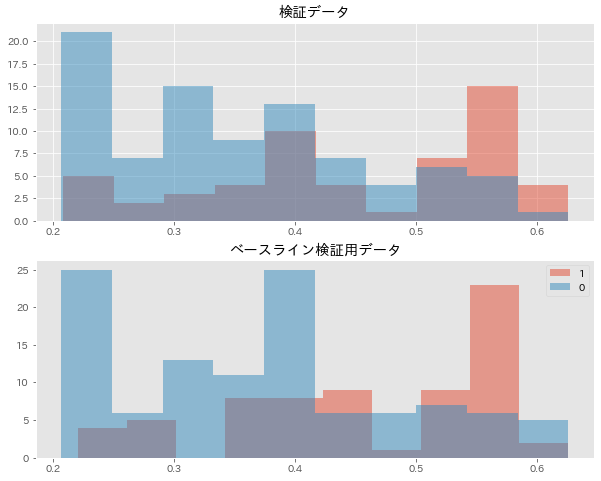

In [176]:
# 4-23 予測値の分布比較
# 予測値の確率値算出
y_va1_pred_prob = model.predict_proba(x_va1)[:,1]
y_va2_pred_prob = model.predict_proba(x_va2)[:,1]

# 確率値をヒストグラムで可視化
fig = plt.figure(figsize=(10,8))

# 検証データ
fig.add_subplot(2,1,1)
plt.title("検証データ")
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label="1")
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label="0")

# ベースライン検証用データ
fig.add_subplot(2,1,2)
plt.title("ベースライン検証用データ")
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label="1")
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label="0")

plt.grid()
plt.legend()

## 4.8 モデル推論

### 4.8.1 推論用データセット作成

In [182]:
# 4-24 推論用データセットの作成
df_test = pd.read_csv("../titanic/test.csv")
x_test = df_test[["Pclass", "Fare"]]
id_test = df_test[["PassengerId"]]

### 4.8.2 学習済みモデルを用いた推論

In [183]:
# 4-25 学習モデルによる推論
y_test_pred = model.predict(x_test)

In [184]:
# 4-26 提出用ファイルの作成
df_submit = pd.DataFrame({"PassengerId":id_test["PassengerId"],"Survived":y_test_pred})
display(df_submit.head(5))
df_submit.to_csv("submission_baseline.csv", index=None)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
